In [104]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import rfft
import numpy.random as rand
import ArtificialData
import importlib
importlib.reload(ArtificialData)


<module 'ArtificialData' from '/Users/cassiopeia/Desktop/ASTR5470/Fourier-Transform-Light-Periodicy/ArtificialData.py'>

Artificial Data formation and Alteration/ Pulse Profile 

Text(0, 0.5, 'Radio Photons')

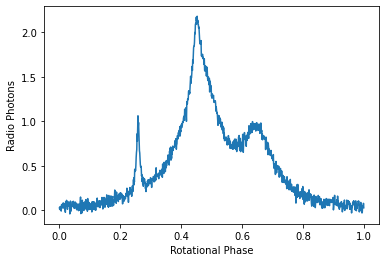

In [119]:
# Phi establishes the rotational phase 
phi = np.linspace(0, 1, 1024)
# .generate_dummy (number of artificial pulses, number of phase bins )
pulses, locs = ArtificialData.generate_dummy(1,1024, 1, 2000)


np.savez('TestData.npz', *[pulses, locs], **{'pulses' : pulses, 'locs': locs})

# Plotting the Data for a general view 
pulses, locs, gammas, amps = ArtificialData.generate(1, 1024)
plt.plot(phi, pulses[0])
plt.xlabel('Rotational Phase')
plt.ylabel('Radio Photons')
 

In [120]:
from scipy.signal import unit_impulse as delta
# delta function returns array where all the entries are 0 except for 1 
print(delta(5))

[1. 0. 0. 0. 0.]


Main Code: Converting Pulse Data into Harmonics Using FFT 

In [121]:
# repeats unit impulse/delta function
# spacing is n_bin in periodicity 
def shah(period, n = 50): # shah is a train of delta functions
    shah_list = []
    for i in range(n):
        shah_list.extend(delta(period))
    return np.array(shah_list)

Text(0.5, 1.0, 'Artificial Light Data')

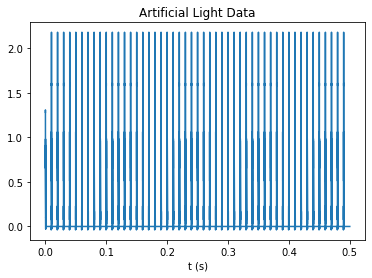

In [122]:
# In order to create the pulse train of repeatin pulse profile that we created earlier and 
# the shah function is being used for the amount of times we are repeating 
# 
pulse_train = np.convolve(pulses[0], shah(10000), mode = 'same' )
x_untits = np.array(range(len(pulse_train)))/1e6 # converting from microsec to seconds

plt.plot(x_untits, pulse_train)
plt.xlabel('t (s)')
plt.title('Artificial Light Data')


Text(0, 0.5, 'Arbitrary Power')

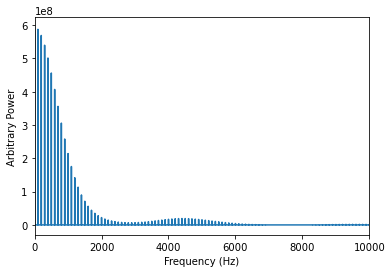

In [124]:
# This is the 
trainFFT = abs(np.fft.rfft(pulse_train))**2
x_untits = 1e6*np.array(range(len(trainFFT)))/len(pulse_train) #converting microseconds to seconds / x units 
plt.plot(x_untits, trainFFT)
# Alter the Xlim to allow for any changes within the harmonics 
plt.xlim(0, 10000)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Arbitrary Power')
# x axis needs frq resolution which is 1/total number of bins
# y axis arbitrary power 